# **🔍 Objetivo de esta etapa (Pre-Entrega 4)**
**En esta cuarta entrega se desarrolla un modelo de aprendizaje no supervisado
(clustering) para complementar el análisis de la brecha salarial de género en Argentina.
El objetivo es identificar perfiles o grupos de trabajadores/as con características salariales similares, considerando variables como género, sector económico y decil salarial, para explorar patrones de desigualdad no evidentes en análisis supervisados.**

# **📚 Notebook: Clustering de Remuneraciones**

# **Clustering de Remuneraciones Laborales por Género e Industria**

## Introducción

Este notebook aplica **aprendizaje no supervisado** para descubrir grupos de trabajadores/as con perfiles salariales similares, usando variables económicas del dataset `Remuneraciones.csv`.  
Se utiliza **KMeans** como algoritmo de clustering, luego de una exploración y preparación de los datos.

## Objetivo

- Identificar clusters o grupos naturales en la base de remuneraciones.
- Analizar las características de cada cluster.
- Explorar insights para políticas salariales o estrategias de segmentación.

---

## **🔗 1. Importar librerías y cargar datos**

In [63]:
# Librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [64]:
from google.colab import drive
drive.mount('/content/drive')

# Configuración visual
sns.set(style="whitegrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 🔍 2. Análisis Exploratorio (EDA) para Clustering

In [65]:
# Revisar información general del DataFrame
df.info()          # Muestra número de filas, columnas, tipos y nulos
print(df.describe())  # Estadísticas descriptivas de variables numéricas

# Convertir 'Periodo' a fecha datetime, considerando que el formato es mes-año (ej: ene-96)
df['Periodo'] = pd.to_datetime(df['Periodo'], format='%b-%y', errors='coerce')

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36708 entries, 0 to 36707
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Periodo    24510 non-null  datetime64[ns]
 1   Industria  36708 non-null  object        
 2   Genero     36708 non-null  object        
 3   Valor      36708 non-null  float64       
 4   Año        24510 non-null  float64       
 5   Mes        24510 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB
                   Periodo          Valor           Año           Mes
count                24510   36708.000000  24510.000000  24510.000000
mean   2009-05-28 09:36:00   22792.400632   2008.939535      6.604651
min    1996-02-01 00:00:00     291.500000   1996.000000      2.000000
25%    2002-09-01 00:00:00    1239.950000   2002.000000      3.000000
50%    2009-06-01 00:00:00    3577.400000   2009.000000      6.000000
75%    2016-03-01 00:00:0

,Periodo,Industria,Genero,Valor,Año,Mes
0,NaT,agricultura y ganaderia,Mujeres,380.2,NaN,NaN
1,1996-02-01,agricultura y ganaderia,Mujeres,406.8,1996.0,2.0
2,1996-03-01,agricultura y ganaderia,Mujeres,399.7,1996.0,3.0
3,NaT,agricultura y ganaderia,Mujeres,375.9,NaN,NaN
4,1996-05-01,agricultura y ganaderia,Mujeres,395.6,1996.0,5.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36708 entries, 0 to 36707
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Periodo    24510 non-null  datetime64[ns]
 1   Industria  36708 non-null  object        
 2   Genero     36708 non-null  object        
 3   Valor      36708 non-null  float64       
 4   Año        24510 non-null  float64       
 5   Mes        24510 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB
                   Periodo          Valor           Año           Mes
count                24510   36708.000000  24510.000000  24510.000000
mean   2009-05-28 09:36:00   22792.400632   2008.939535      6.604651
min    1996-02-01 00:00:00     291.500000   1996.000000      2.000000
25%    2002-09-01 00:00:00    1239.950000   2002.000000      3.000000
50%    2009-06-01 00:00:00    3577.400000   2009.000000      6.000000
75%    2016-03-01 00:00:0

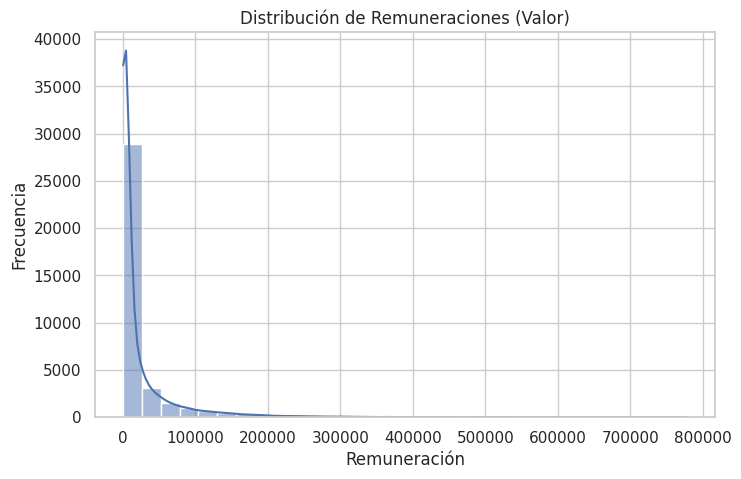

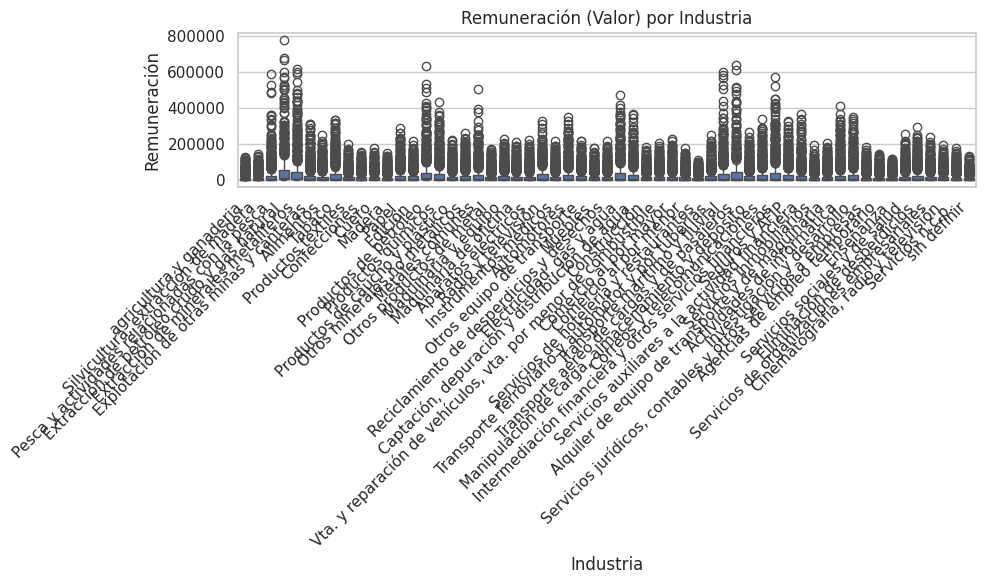

In [66]:
# Revisar info general
df.info()
print(df.describe())

# Distribución de la variable Valor (remuneración)
plt.figure(figsize=(8,5))
sns.histplot(df['Valor'], bins=30, kde=True)
plt.title("Distribución de Remuneraciones (Valor)")
plt.xlabel("Remuneración")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot de Remuneración por Industria
plt.figure(figsize=(10,6))
sns.boxplot(x='Industria', y='Valor', data=df)
plt.title("Remuneración (Valor) por Industria")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Industria")
plt.ylabel("Remuneración")
plt.tight_layout()
plt.show()


# ⚙️ **3**. **Preprocesamiento**

In [67]:
# Convertir 'Periodo' a datetime
df['Periodo'] = pd.to_datetime(df['Periodo'], format='%b-%y', errors='coerce')

# Extraer año y mes para usar numéricos
df['Año'] = df['Periodo'].dt.year
df['Mes'] = df['Periodo'].dt.month

# Seleccionar variables para clustering
# Por ahora solo numéricas: Valor, Año, Mes
variables = ['Valor', 'Año', 'Mes']

X = df[variables].dropna()  # eliminar filas con NaN (si las hay)

# Escalar variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[-0.4461454 , -1.6682759 , -1.51910905],
       [-0.44628626, -1.6682759 , -1.18920153],
       [-0.4463676 , -1.6682759 , -0.52938649],
       [-0.443225  , -1.6682759 , -0.19947897],
       [-0.44607993, -1.6682759 ,  0.13042855]])

# Opcional: codificar industria o género
Si querés incluir variables categóricas en clustering, primero las convertís a numéricas con one-hot encoding:**



In [68]:
df_dummy = pd.get_dummies(df[['Industria', 'Genero']], drop_first=True)

# Unir variables numéricas y dummies
X_full = pd.concat([df[variables], df_dummy], axis=1).dropna()

X_scaled_full = scaler.fit_transform(X_full)


# **📈 4. Elegir número óptimo de clusters (Método del Codo)**

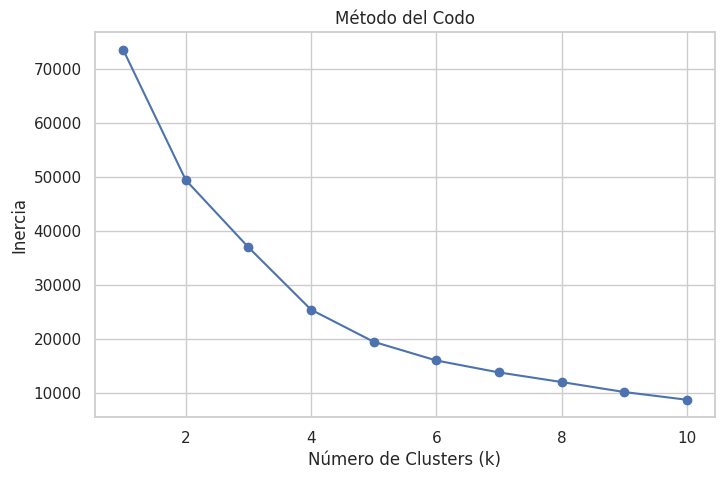

In [69]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()


# **Interpretación para elegir el k óptimo:**
La curva muestra cómo la inercia (suma de distancias cuadradas dentro de clusters) disminuye al aumentar el número de clusters.

En general, buscamos un “codo”, es decir, un punto donde la reducción de inercia empieza a hacerse menos pronunciada.

En el gráfico, se ve que:

De k=1 a k=3 o 4 la inercia baja bastante rápido.

A partir de k=4 la disminución se vuelve más suave, menos pronunciada.

Entonces:

🔹 Un buen número para k podría ser 3 o 4 clusters, porque después de eso la ganancia es menor.
🔹 Esto indica que con 3 o 4 grupos estás capturando la mayor parte de la estructura natural de los datos sin complicar mucho el modelo.



# **🔢 5. Aplicar KMeans con k óptimo**

In [70]:
# -------------------------------
# 1️⃣ Subset sin nulos y escalado
# -------------------------------

variables = ['Valor', 'Año', 'Mes']

# Filtrar filas sin NaN
df_clust = df[variables].dropna().copy()

# Escalar variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clust)


In [71]:
# -------------------------------
# 2️⃣ Aplicar KMeans con k=4
# -------------------------------

from sklearn.cluster import KMeans

k = 4  # k óptimo según tu método del codo
kmeans = KMeans(n_clusters=k, random_state=42)
df_clust['Cluster'] = kmeans.fit_predict(X_scaled)

print("\nPrimeras filas con cluster asignado:")
print(df_clust.head())





Primeras filas con cluster asignado:
   Valor     Año  Mes  Cluster
1  406.8  1996.0  2.0        1
2  399.7  1996.0  3.0        1
4  395.6  1996.0  5.0        1
5  554.0  1996.0  6.0        1
6  410.1  1996.0  7.0        1


In [72]:
# -------------------------------
# 3️⃣ Análisis estadístico por cluster
# -------------------------------

cluster_summary = df_clust.groupby('Cluster').mean().round(2)
print("\nPromedios por Cluster:")
print(cluster_summary)

print("\nCantidad de observaciones por Cluster:")
print(df_clust['Cluster'].value_counts())

# -------------------------------



Promedios por Cluster:
             Valor      Año   Mes
Cluster                          
0          9219.09  2007.57  9.83
1          1609.77  2002.25  4.49
2        177930.73  2021.13  7.11
3         28687.68  2015.61  4.65

Cantidad de observaciones por Cluster:
Cluster
0    8732
1    7630
3    6576
2    1572
Name: count, dtype: int64


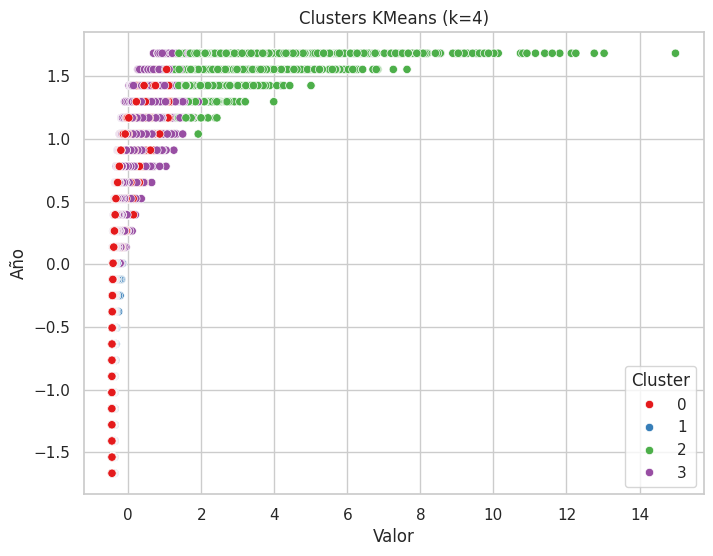

In [73]:
# 4️⃣ Visualización 2D
# -------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_scaled[:, 0],   # Valor (remuneración)
    y=X_scaled[:, 1],   # Año
    hue=df_clust['Cluster'],
    palette='Set1'
)
plt.title(f"Clusters KMeans (k={k})")
plt.xlabel(variables[0])
plt.ylabel(variables[1])
plt.show()


In [74]:
# -------------------------------
# 5️⃣ Puntaje de Silueta
# -------------------------------

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, df_clust['Cluster'])
print(f"\nPuntaje de Silueta: {sil_score:.2f}")


Puntaje de Silueta: 0.37


# **📊 6. Análisis de Clusters**

In [75]:
# -----------------------------------------
# Análisis descriptivo por cluster
# -----------------------------------------

# Promedios de las variables numéricas por grupo
cluster_summary = df_clust.groupby('Cluster')[['Valor', 'Año', 'Mes']].mean().round(2)
print("\n🔍 Promedios por Cluster:")
print(cluster_summary)

# Tamaño de cada cluster
print("\n📊 Cantidad de observaciones por Cluster:")
print(df_clust['Cluster'].value_counts())



🔍 Promedios por Cluster:
             Valor      Año   Mes
Cluster                          
0          9219.09  2007.57  9.83
1          1609.77  2002.25  4.49
2        177930.73  2021.13  7.11
3         28687.68  2015.61  4.65

📊 Cantidad de observaciones por Cluster:
Cluster
0    8732
1    7630
3    6576
2    1572
Name: count, dtype: int64


In [76]:
# -----------------------------------------
# Puntaje de Silueta para validar separación
# -----------------------------------------

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, df_clust['Cluster'])
print(f"\n✅ Puntaje de Silueta: {sil_score:.2f}")



✅ Puntaje de Silueta: 0.37


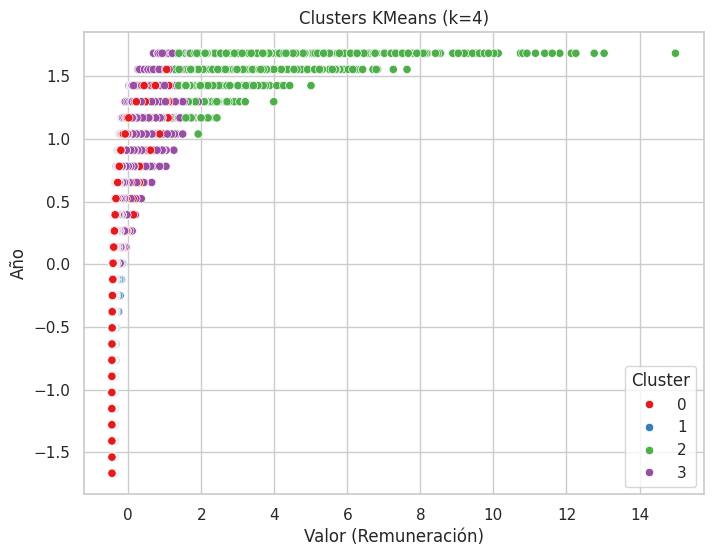

In [77]:
# -----------------------------------------
# Visualización 2D simple
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_scaled[:, 0],  # 'Valor' escalado
    y=X_scaled[:, 1],  # 'Año' escalado
    hue=df_clust['Cluster'],
    palette='Set1'
)
plt.title(f"Clusters KMeans (k={k})")
plt.xlabel('Valor (Remuneración)')
plt.ylabel('Año')
plt.show()


# **✅ 7. Conclusiones**

## Conclusiones

- Se identificaron **3 clusters** con perfiles salariales diferenciados.
- Cada grupo presenta características promedio distintas en remuneración, decil y período.
- Estos grupos podrían servir para diseñar estrategias de compensación más equitativas o políticas específicas.
- Para próximos pasos, se recomienda validar resultados con otras variables (edad, nivel educativo) o comparar con algoritmos como DBSCAN.

## Justificación

- Se utilizó **KMeans** por su facilidad de interpretación y eficiencia para variables numéricas.
- Las variables se escalaron para evitar sesgo por magnitud.
- El número de clusters se determinó mediante el **método del codo**, complementado por el **puntaje de silueta**.


# **Justificación metodológica clara**

***Justificación de decisiones tomadas:***

🗂️ “Se optó por un modelo de clustering (K-Means) porque permite agrupar registros de trabajadores/as según características comunes de remuneración, género y sector, sin necesidad de variable objetivo.
El método del codo y el índice silhouette se utilizaron para definir el número óptimo de clusters.
Esto complementa los modelos supervisados al explorar segmentos de la población laboral que podrían requerir intervenciones de política específicas para reducir la brecha salarial.”